TODO citations

#### Context

I'm trying to rewrite XTTS in JAX to understand how it works. 

We are going to implement the VQVAE used in [XTTS](https://github.com/coqui-ai/TTS), a Text to Speech model written by the defunct Coqai company. VQVAEs come from this paper: [Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937)

VQVAE means Vector Quantized Variational AutoEncoder. Let's break down the name. 

__Auto-Encoder__

This model takes the input, passes it through smaller layers (Encodes) and tries to, from that small layer, reproduce the input (Decodes). It thus needs to learn what are the most important features to keep ! If the input was images of cats, the model would keep information about the color, way it's looking, thiccness of the cat.

__Variational__

Instead of having to encode inputs onto points in space we map them onto distributions. TODO

__Vector Quantized__

We want to define a set of points in the smaller representation, the latent. These points will be called _codes_ and be part of a _codebook_. Think of the codebook as the set of possible words the encoder can use to describe what it sees to the decoder. Obviously, the more codes we have, the more information the encoder will be able to pass per code sent.

TODO images

#### Goal

Our VQVAE is going to find the best codes that describe speech. It'll take in special images called Mel-Frequency Spectrograms, which is basically a way to represent human speech.

Since our final goal is to recreate a 1 to 1 version of the VQVAE used in XTTS, we'll hardcode a lot of things to minimize issues.

```python
DiscreteVAE(
  (discrete_loss): DiscretizationLoss()
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(80, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): ReLU()
    )
    (2): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (4): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (5): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
    (1): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (2): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (3): ResBlock(
      (net): Sequential(
        (0): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU()
        (2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (4): Sequential(
      (0): UpsampledConv(
        (conv): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
    )
    (5): Sequential(
      (0): UpsampledConv(
        (conv): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
    )
    (6): Conv1d(512, 80, kernel_size=(1,), stride=(1,))
  )
  (codebook): Quantize()
)
```

We have 4 parts to code: An ResBlock, Encoder, a Decoder and a Quantizer. Let's get into it!

Importing JAX and Equinox, a library that helps with writing neural networks.

In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import typing as tp


#### ResBlock

The role of this Block is to mainly exchange information between the various parts of each channel, but the input is added at the end. This allows our network to basically, if suitable, simply put all weights to zero and be "Shallower" basically our network decides how many layers it needs !

In [2]:

class ResBlock(eqx.Module):
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    act: tp.Callable = eqx.static_field()

    def __init__(self, dim: int, activation = jax.nn.relu, key=None):
        
        key1, key2, key3 = jax.random.split(key, 3)

        self.conv1 = nn.Conv1d(dim, dim, kernel_size=3, padding="SAME", key=key1)
        self.conv2 = nn.Conv1d(dim, dim, kernel_size=3, padding="SAME", key=key2)
        self.conv3 = nn.Conv1d(dim, dim, kernel_size=1, padding="SAME", key=key3)

        self.act = activation

    def __call__(self, x):
        y = x

        y = self.conv1(y)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)

        y = y + x

        return y


#### Encoder

Moving onto the Encoder. It has layers that take in the input, and slowly compress it by lowering the image dimensions and increasing the amounts of channels, much like ResNet:

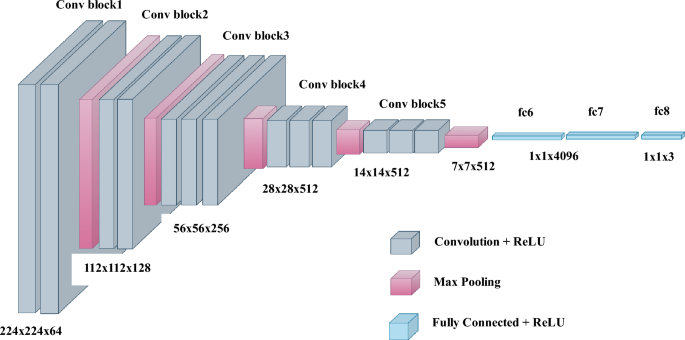 TODO cite image https://www.nature.com/articles/s41598-023-37743-4/figures/3

In [3]:

class Encoder(eqx.Module):
    conv1: nn.Conv1d
    conv2: nn.Conv1d
    conv3: nn.Conv1d
    res1: ResBlock
    res2: ResBlock
    res3: ResBlock

    def __init__(self, hidden_dim: int = 1024, codebook_dim: int = 512, key=None):
        key1, key2, key3, key4, key5, key6 = jax.random.split(key, 6)

        self.conv1 = nn.Conv1d(in_channels=80, out_channels=512, kernel_size=3, stride=2, padding="SAME", key=key1)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=hidden_dim, kernel_size=3, stride=2, padding="SAME", key=key2)
        self.res1 = ResBlock(dim=hidden_dim, key=key3)
        self.res2 = ResBlock(dim=hidden_dim, key=key4)
        self.res3 = ResBlock(dim=hidden_dim, key=key5)
        self.conv3 = nn.Conv1d(in_channels=hidden_dim, out_channels=codebook_dim, kernel_size=1, stride=1, padding="SAME", key=key6)

    def __call__(self, x):

        y = self.conv1(x)
        y = jax.nn.relu(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.conv3(y)

        return y

#### UpsampledConv

Before we move onto the decoder we have to define a special layer that replaces the ConvTranspose that we would normally use. TODO understand I admit I still am still not sure why they use this instead.

Their code for this function:

```python
class UpsampledConv(nn.Module):
    def __init__(self, conv, *args, **kwargs):
        super().__init__()
        assert "stride" in kwargs.keys()
        self.stride = kwargs["stride"]
        del kwargs["stride"]
        self.conv = conv(*args, **kwargs)

    def forward(self, x):
        up = nn.functional.interpolate(x, scale_factor=self.stride, mode="nearest")
        return self.conv(up)
```

Let's test their function to see how it behaves and then write our own and reproduce results just to be sure. TODO close this 

In [4]:
import torch
import numpy
class UpsampledConv(torch.nn.Module):
    def __init__(self, conv, *args, **kwargs):
        super().__init__()
        assert "stride" in kwargs.keys()
        self.stride = kwargs["stride"]
        del kwargs["stride"]
        self.conv = conv(*args, **kwargs)

    def forward(self, x):
        up = torch.nn.functional.interpolate(x, scale_factor=self.stride, mode="nearest")
        print(up.shape)
        return self.conv(up)
    
upsamp = UpsampledConv(torch.nn.Conv1d, 80, 512, 3, stride=2, padding=1)
x = torch.ones((3, 80, 100))
print(upsamp(x).shape)


torch.Size([3, 80, 200])
torch.Size([3, 512, 200])


In [5]:
class UpsampledConv(eqx.Module):
    conv: nn.Conv1d
    stride: int = eqx.static_field()

    def __init__(self, in_channels:int, out_channels:int, kernel_size:tp.Union[int, tp.Tuple[int]], stride:int, padding:tp.Union[int, str], key=None ):
        super().__init__()
        self.stride = stride
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=padding, key=key)

    def __call__(self, x):
        upsampled_size = (x.shape[0], x.shape[1] * self.stride)
        upsampled = jax.image.resize(x, upsampled_size, method="nearest")
        return self.conv(upsampled)
    


In [6]:
key = jax.random.PRNGKey(1)
upsamp = UpsampledConv(80, 150, kernel_size=3, stride=2, padding="SAME", key=key)
x = jax.random.normal(key, shape=(80, 100))
y = upsamp(x)
print(x.shape)
print(y.shape)

(80, 100)
(150, 200)


#### Decoder

We can now implement the decoder.

In [7]:
class Decoder(eqx.Module):
    conv1: nn.Conv1d
    conv2: UpsampledConv
    conv3: UpsampledConv
    conv4: nn.Conv1d
    res1: ResBlock
    res2: ResBlock
    res3: ResBlock

    def __init__(self, hidden_dim: int = 1024, codebook_dim: int = 512, key=None):
        key1, key2, key3, key4, key5, key6, key7 = jax.random.split(key, 7)

        self.conv1 = nn.Conv1d(in_channels=codebook_dim, out_channels=hidden_dim, kernel_size=1, stride=1, padding="SAME", key=key1)
        self.res1 = ResBlock(dim=hidden_dim, key=key2)
        self.res2 = ResBlock(dim=hidden_dim, key=key3)
        self.res3 = ResBlock(dim=hidden_dim, key=key4)
        self.conv2 = UpsampledConv(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=2, padding="SAME", key=key5)
        self.conv3 = UpsampledConv(in_channels=hidden_dim, out_channels=512, kernel_size=3, stride=2, padding="SAME", key=key6)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=80, kernel_size=1, stride=1, padding="SAME", key=key7)

    def __call__(self, x):

        y = self.conv1(x)
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.conv2(y)
        y = jax.nn.relu(y)
        y = self.conv3(y)
        y = jax.nn.relu(y)
        y = self.conv4(y)

        return y

After having implemented various VQVAEs, what strikes me in this one is that the ResBlocks are all seperated from the various convolutional stages, and the lack of normalisation between layers. Moving onto the crux of the matter, the Quantizer !

#### Quantizer

So our encoder spits out a certain number of vectors (The number of channels) with the codebook dim. These vectors are mapped to their nearest neighbors, and these respective neighbors are the vectors that will be sent to the decoder.

In [8]:
class Quantizer(eqx.Module):
    K: int = eqx.static_field()
    D: int = eqx.static_field()
    codebook: jax.Array

    codebook_avg: jax.Array
    cluster_size: jax.Array

    decay: float = eqx.static_field()
    eps: float = eqx.static_field()

    def __init__(self, num_vecs: int = 1024, num_dims: int = 512, decay: float = 0.99, eps: float = 1e-5, key=None):
        self.K = num_vecs
        self.D = num_dims

        self.decay = decay
        self.eps = eps

        # Init a matrix of vectors that will move with time
        self.codebook = jax.nn.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")(key, (num_vecs, num_dims))
        self.codebook_avg = jnp.copy(self.codebook)
        self.cluster_size = jnp.zeros(num_vecs)

    def __call__(self, x):
        # x has N vectors of the codebook dimension. We calculate the nearest neighbors and output those instead
    
        
        flatten = jax.numpy.reshape(x, (-1, self.D))
        a_squared = jnp.sum(flatten**2, axis=-1, keepdims=True)
        b_squared = jnp.transpose(jnp.sum(self.codebook**2, axis=-1, keepdims=True))
        distance = a_squared + b_squared - 2*jnp.matmul(flatten, jnp.transpose(self.codebook))

        codebook_indices = jnp.argmin(distance, axis=-1)

        z_q = self.codebook[codebook_indices]

        # Straight-through estimator
        z_q = flatten + jax.lax.stop_gradient(z_q - flatten)

        z_q = jax.numpy.reshape(z_q, (-1, x.shape[-1]))

        return z_q, self.codebook_updates(flatten, codebook_indices)

    def codebook_updates(self, flatten, codebook_indices):

        # Calculate the usage of various codes.
        codebook_onehot = jax.nn.one_hot(codebook_indices, self.K)
        codebook_onehot_sum = jnp.sum(codebook_onehot, axis=0)
        codebook_sum = jnp.dot(flatten.T, codebook_onehot)
        # We've just weighed the codebook vectors.

        # Basically count on average how many codes we're using
        new_cluster_size = self.decay * self.cluster_size + (1 - self.decay) * codebook_onehot_sum

        # Where is the average embedding at ?
        new_codebook_avg = self.decay * self.codebook_avg + (1 - self.decay) * codebook_sum.T

        n = jnp.sum(new_cluster_size) # Over the total embeddings used
        new_cluster_size = (new_cluster_size + self.eps) / (n + self.K * self.eps) * n
        new_codebook = self.codebook_avg / new_cluster_size[:, None]

        updates = (new_cluster_size, new_codebook_avg, new_codebook)

        return updates, codebook_indices
    
    def inference(self, x):
        # x has N vectors of the codebook dimension. We calculate the nearest neighbors and output those instead
    
        
        flattened_x = jax.numpy.reshape(x, (-1, self.D))
        a_squared = jnp.sum(flattened_x**2, axis=-1, keepdims=True)
        b_squared = jnp.transpose(jnp.sum(self.codebook**2, axis=-1, keepdims=True))
        distance = a_squared + b_squared - 2*jnp.matmul(flattened_x, jnp.transpose(self.codebook))

        encoding_indices = jnp.reshape(
            jnp.argmin(distance, axis=-1), flattened_x.shape[0]
        )

        z_q = self.codebook[encoding_indices]

        # Straight-through estimator
        z_q = flattened_x + jax.lax.stop_gradient(z_q - flattened_x)

        z_q = jax.numpy.reshape(z_q, (-1, x.shape[-1]))
        
        return z_q, encoding_indices

What the above does is create K vectors in D dimensional space. Incoming vectors find their nearest match and the loss calculated is the L2 distance.

TODO Explain straight through estimator. Implement the losses here or do them outside ? Hmm. The codebook is normalized during training. 

Our model is going to have 3 losses: We want an MSE loss, the reconstruction loss, that will calculate at what point the reproduced data is correct. We want to then calculate losses that will move encoder outputs to the codebook vectors and vice-versa. 

Let's do a quick test on the full model to make sure that the whole works correctly.

We can see that we go from a 80 x X long spectrogram and go down to a 512 x X / 4 image, which to be fair seems kind of dumb because we actually don't loose any information like this. We could have a 1 to 1 reproduction of the image... was it not for the quantizer in the middle that forces us to assign the image to actually, only X/4 vectors ! Whatever the dimension of these vectors, the information we encode can this be counted in $log_2(x/4)$ bits 😎

Let's finish up by defining a final Module that wraps all of this up, and defining our training.

In [9]:
class VQVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    quantizer: Quantizer

    def __init__(self, key=None):
        key1, key2, key3 = jax.random.split(key, 3)
        
        self.encoder = Encoder(key=key1)
        self.decoder = Decoder(key=key2)
        self.quantizer = Quantizer(key=key3)

    def __call__(self, x):
        z_e = self.encoder(x)
        z_q, codebook_indices = self.quantizer(z_e)
        y = self.decoder(z_q)

        return z_e, z_q, codebook_indices, y

In [13]:
import optax
from tensorboardX import SummaryWriter


def update_codebook_ema(model: VQVAE, updates: tuple, codebook_indices, key=None):
    avg_updates = jax.tree.map(lambda x: jax.numpy.mean(x, axis=0), updates)
    # print(avg_updates)
    h = jnp.histogram(codebook_indices, bins=model.quantizer.K, range=(0, model.quantizer.K))[0] / len(codebook_indices)
    part_that_should_be = 1/model.quantizer.K
    mask = (h > 2 * part_that_should_be) | (h < 0.5 * part_that_should_be)
    
    rand_embed = jax.random.normal(key, (model.quantizer.K, model.quantizer.D)) * mask[:, None]
    avg_updates = (avg_updates[0], avg_updates[1], jnp.where(mask[:, None], rand_embed, avg_updates[2]))
    
    where = lambda q: (q.quantizer.cluster_size, q.quantizer.codebook_avg, q.quantizer.codebook)
    # Apply updates using tree_at
    model = eqx.tree_at(where, model, avg_updates)
    return model


@eqx.filter_jit
@eqx.filter_value_and_grad(has_aux=True)
def calculate_losses(model, x):
    z_e, z_q, codebook_updates, y = jax.vmap(model)(x)

    reconstruct_loss = jnp.mean(jnp.linalg.norm((x - y), ord=2, axis=(1,2)))

    commit_loss = jnp.mean(jnp.linalg.norm(z_e - jax.lax.stop_gradient(z_q), ord=2, axis=(1,2)))
    
    codebook = jnp.mean(codebook_updates[0][2], axis=0)
    # print(codebook.shape)
    # print(codebook)
    # print(jnp.mean(codebook, axis=-1).shape)
    # print(f"STDR: {jnp.std(codebook, axis=-1)}")
    # print(f"log: {jnp.log(jnp.clip(jnp.mean(codebook, axis=-1), min=1e-5)) }")
    
    KL_loss = 0.5 * jnp.sum(jnp.mean(codebook, axis=-1)**2 + jnp.var(codebook, axis=-1) - jnp.log(jnp.clip(jnp.std(codebook, axis=-1), min=1e-6)) - 1)

    total_loss = reconstruct_loss + commit_loss

    return total_loss, (reconstruct_loss, commit_loss, KL_loss, codebook_updates, y)

@eqx.filter_jit
def make_step(model, optimizer, opt_state, x, key):
    (total_loss, (reconstruct_loss, commit_loss, KL_loss, codebook_updates, y)), grads = calculate_losses(model, x)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    model = update_codebook_ema(model, codebook_updates[0], codebook_updates[1], key)

    return model, opt_state, total_loss, reconstruct_loss, commit_loss, KL_loss,codebook_updates, y

key = jax.random.PRNGKey(69)

model = VQVAE(key=key)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs')

for i in range(0, 100):
    x = jnp.ones((10, 80, 100))
    model, opt_state, total_loss, reconstruct_loss, commit_loss, KL_loss, codebook_updates, y = make_step(model, optimizer, opt_state, x)
    print(f"Total loss: {total_loss}")

    # Log codebook updates to TensorBoard
    writer.add_scalar('Loss/Total', total_loss, i)
    writer.add_scalar('Loss/Reconstruct', reconstruct_loss, i)
    writer.add_scalar('Loss/Commit', commit_loss, i)
    writer.add_scalar('Loss/KL loss', KL_loss, i)
    # writer.add_histogram('Codebook Updates/Cluster Size', jnp.mean(codebook_updates[0], axis=0), i)
    # writer.add_scalar('Codebook Updates/Codebook Avg', jnp.mean(codebook_updates[1], axis=0), i)
    writer.add_histogram('Codebook Updates/Code ids used', jnp.sum(codebook_updates[1], axis=(0)), i)
    writer.add_histogram('Codebook Updates/Code means', jnp.mean(codebook_updates[0][2], axis=(0,2)), i)
    writer.add_histogram('Codebook Updates/Code stds', jnp.std(codebook_updates[0][2], axis=(0,2)), i)


TypeError: missing a required argument: 'key'

We now have a variational autoencoder - It takes in inputs, autoencodes them into a latent space but instead of poping out simply a vector it should also pop out two values to describe the distribution of that input: mean and variance.

Let's download some data and make runs through to see if it can learn from it ! 

XTTS has this function that seems to transform the incoming wav files into nice mel_spectrograms. To optimize the time spent loading the data, we'll transform all the data into input arrays first, and then during the run load from those instead.

```python
def dvae_wav_to_mel(
    wav, mel_norms_file="../experiments/clips_mel_norms.pth", mel_norms=None, device=torch.device("cpu")
):
    mel_stft = torchaudio.transforms.MelSpectrogram(
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        power=2,
        normalized=False,
        sample_rate=22050,
        f_min=0,
        f_max=8000,
        n_mels=80,
        norm="slaney",
    ).to(device)
    wav = wav.to(device)
    mel = mel_stft(wav)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    if mel_norms is None:
        mel_norms = torch.load(mel_norms_file, map_location=device)
    mel = mel / mel_norms.unsqueeze(0).unsqueeze(-1)
    return mel
```

In [ ]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2

In [ ]:
!tar -xvjf ./LJSpeech-1.1.tar.bz2

In [ ]:
import torchaudio
from pathlib import Path
import librosa
import torch
from tqdm import tqdm
import numpy

sample_rate = 22050

def dvae_wav_to_mel(
    wav, mel_norms_file="./mel_stats.pth", mel_norms=None, device=torch.device("cpu")
):
    mel_stft = torchaudio.transforms.MelSpectrogram(
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        power=2,
        normalized=False,
        sample_rate=22050,
        f_min=0,
        f_max=8000,
        n_mels=80,
        norm="slaney",
    ).to(device)
    wav = wav.to(device)
    mel = mel_stft(wav)
    mel = torch.log(torch.clamp(mel, min=1e-5))
    if mel_norms is None:
        mel_norms = torch.load(mel_norms_file, map_location=device)
    mel = mel / mel_norms.unsqueeze(0).unsqueeze(-1)
    return mel

# import matplotlib.pyplot as plt

dataset_dest_path = "dataset/mels"

files = list(Path("./LJSpeech-1.1").rglob("*.wav"))
def boop():
    for file in tqdm(files):
        y, sr = librosa.load(file)
        if sr != sample_rate:
            y = librosa.resample(y, orig_sr=sr, target_sr=sample_rate)
        y = torch.from_numpy(y)
        mel = dvae_wav_to_mel(y)
        
        data = mel.cpu().numpy()
        save_path = Path(dataset_dest_path, f"{file.stem}.npy")
        # print(save_path)
        numpy.save(save_path, data)

        # plt.imshow(mel[0])
        # # plt.show()
        # print(mel)

        # break

KeyboardInterrupt: 

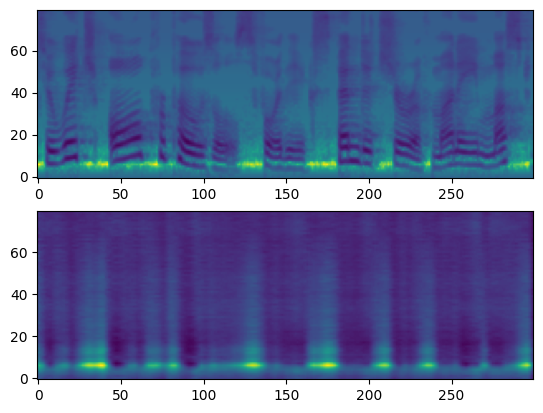

In [ ]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

import datetime
import os
import jax

dataset_path = "dataset/mels"

mel_file_paths = os.listdir(dataset_path)

def truncate_and_pad(audio: jax.Array, width: int = 300):
    audio_length = audio.shape[1]
    target_length = int(width)
    if audio_length > target_length:
        audio = audio[:, :target_length]
    else:
        audio = jnp.pad(audio, ((0, 0), (0, max(0, target_length - audio_length))))
    return audio

def get_batch(idx: list):
    batch = []
    for id in idx:
        array = jax.numpy.load(os.path.join(dataset_path, mel_file_paths[id]))[0]
        padded = truncate_and_pad(array)
        batch.append(padded)
    return jax.numpy.array(batch)
        
key = jax.random.PRNGKey(69)

key1, key2 = jax.random.split(key, 2)

model = VQVAE(key=key1)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 32
fig, (ax1, ax2) = plt.subplots(2)
fig.show()

for epoch in range(epochs):
    key, grab = jax.random.split(key, 2)
    perm = jax.random.permutation(grab, len(mel_file_paths))
    eqx.tree_serialise_leaves(f"checkpoints/{epoch}.eqx", model)

    for i in range(0, len(mel_file_paths), batch_size):
        key, grab = jax.random.split(key, 2)
        batch_ids = perm[i: i + batch_size]
        batch = get_batch(batch_ids)

        model, opt_state, total_loss, reconstruct_loss, commit_loss, KL_Loss, codebook_updates, y = make_step(model, optimizer, opt_state, batch, grab)
        # print(f"Total loss: {total_loss}")

        # Log codebook updates to TensorBoard
        writer.add_scalar('Loss/Total', total_loss, i)
        writer.add_scalar('Loss/Reconstruct', reconstruct_loss, i)
        writer.add_scalar('Loss/Commit', commit_loss, i)
        writer.add_scalar('Loss/KL Loss', KL_Loss, i)
        # writer.add_histogram('Codebook Updates/Cluster Size', jnp.mean(codebook_updates[0], axis=0), i)
        # writer.add_scalar('Codebook Updates/Codebook Avg', jnp.mean(codebook_updates[1], axis=0), i)
        writer.add_histogram('Codebook Updates/Code ids used', jnp.reshape(codebook_updates[1], -1), i)
        writer.add_histogram('Codebook Updates/Code means', jnp.mean(codebook_updates[0][2], axis=(0,2)), i)
        writer.add_histogram('Codebook Updates/Code stds', jnp.std(codebook_updates[0][2], axis=(0,2)), i)
        if (i // batch_size) % 20 == 0:
            print(batch.shape)
            print(y.shape)
            ax1.clear()
            ax2.clear()
            ax1.imshow(batch[0], aspect='auto', origin='lower')
            ax2.imshow(y[0], aspect='auto', origin='lower')
            display(fig)
            clear_output(wait=True)
    # plt.imshow(y[0])


Unfortunately currently it seems like the codes aren't very well spread like a nice Gaussian: ![CleanShot 2024-11-06 at 11.27.20@2x.png](<attachment:CleanShot 2024-11-06 at 11.27.20@2x.png>)
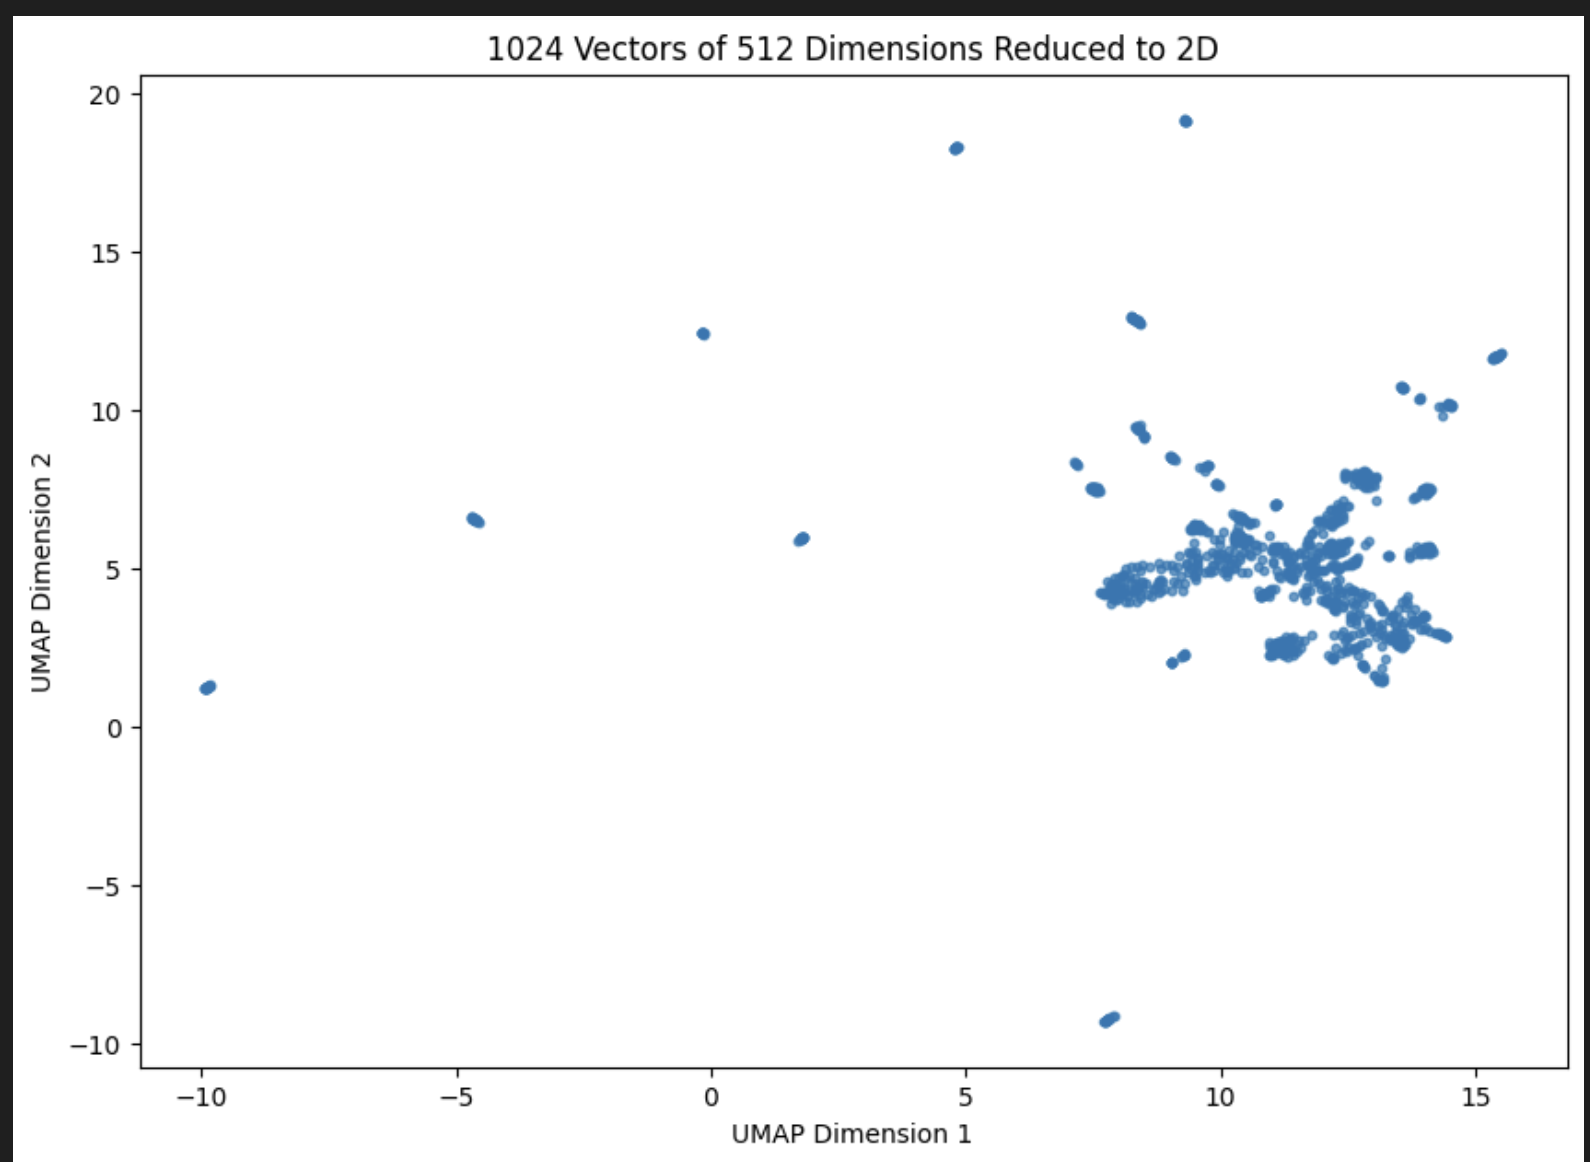

We need to add a KL loss for the model, motivating it to follow a gaussian distribution. After a little big of fighting we get: ![CleanShot 2024-11-06 at 12.05.49@2x.png](<attachment:CleanShot 2024-11-06 at 12.05.49@2x.png>)
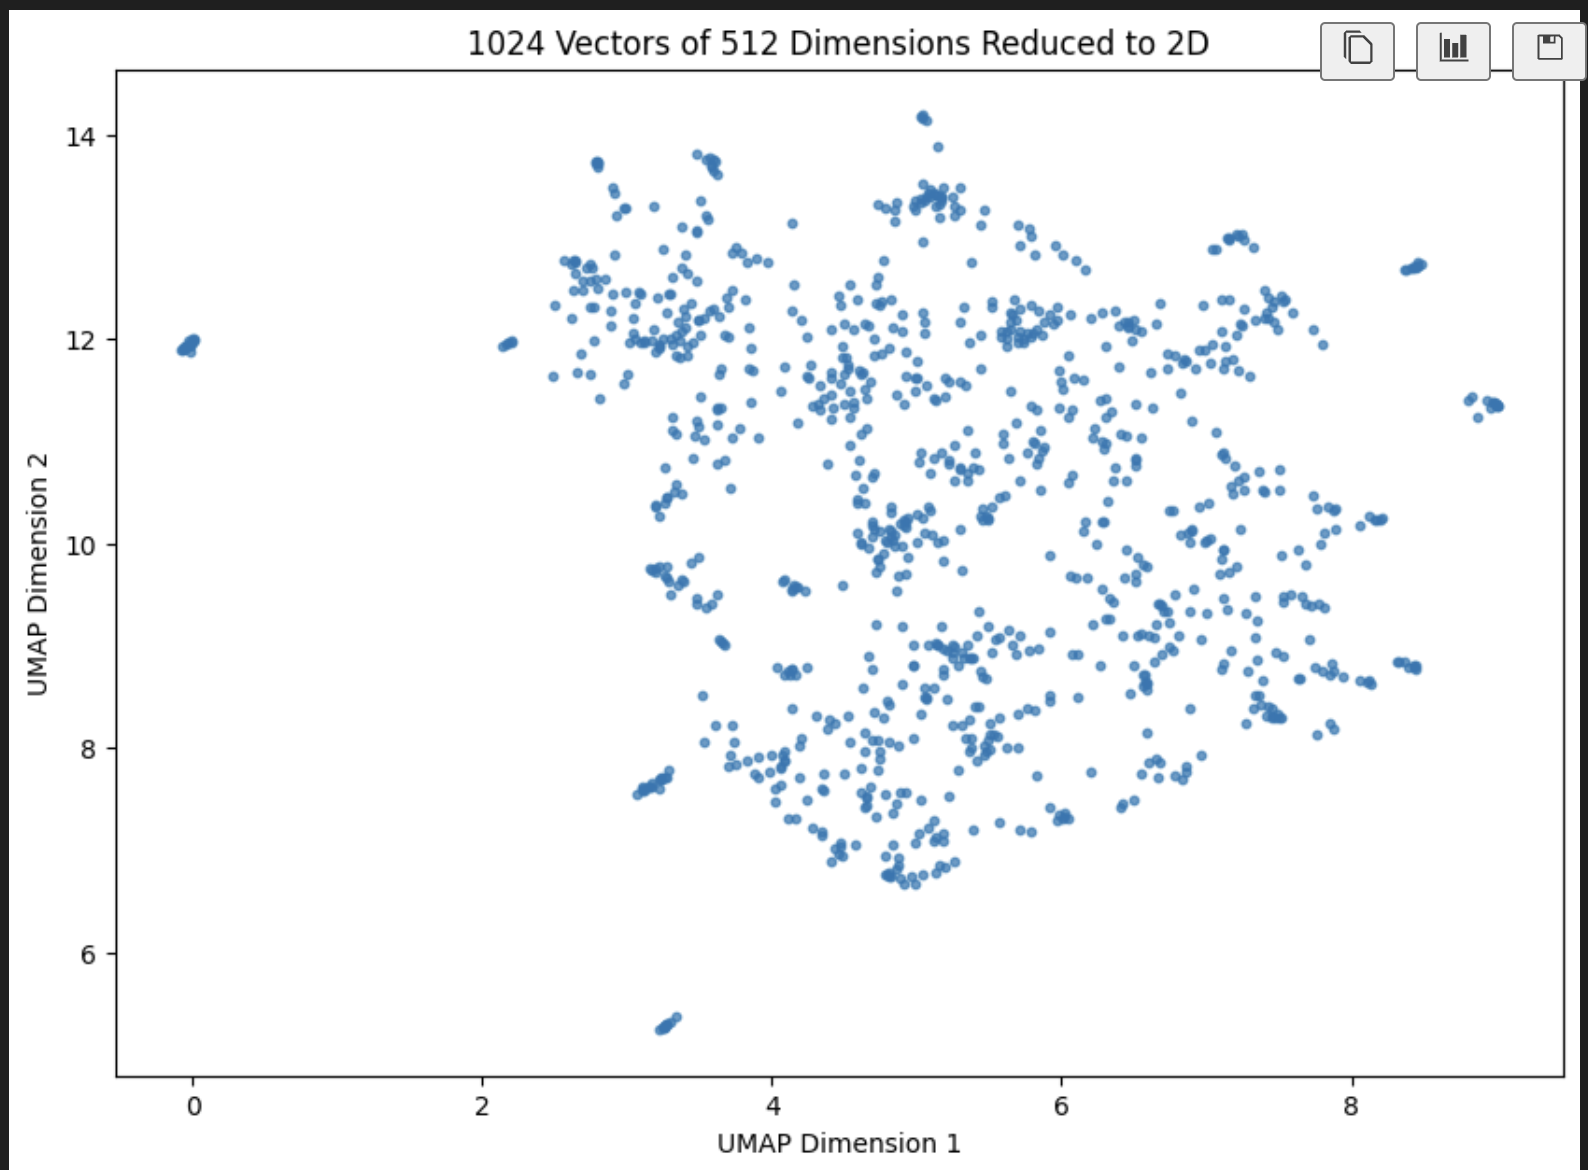

In [ ]:
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

import datetime
import os
import jax

dataset_path = "dataset/mels"

mel_file_paths = os.listdir(dataset_path)

def truncate_and_pad(audio: jax.Array, width: int = 300):
    audio_length = audio.shape[1]
    target_length = int(width)
    if audio_length > target_length:
        audio = audio[:, :target_length]
    else:
        audio = jnp.pad(audio, ((0, 0), (0, max(0, target_length - audio_length))))
    return audio

def get_batch(idx: list):
    batch = []
    for id in idx:
        array = jax.numpy.load(os.path.join(dataset_path, mel_file_paths[id]))[0]
        padded = truncate_and_pad(array)
        batch.append(padded)
    return jax.numpy.array(batch)
        
key = jax.random.PRNGKey(69)

key1, key2 = jax.random.split(key, 2)

model = VQVAE(key=key)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(model)

writer = SummaryWriter(log_dir='./runs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

epochs = 50
batch_size = 32

batch = get_batch([0,1])

model, opt_state, total_loss, reconstruct_loss, commit_loss, KL_Loss, codebook_updates, y = make_step(model, optimizer, opt_state, batch)
# print(f"Total loss: {total_loss}")
# writer.add_histogram('Codebook Updates/Code ids used', jnp.sum(codebook_updates[1], axis=(0)), i)
print(codebook_updates[1].shape)


In [ ]:
print(jnp.reshape(codebook_updates[1], -1))